# Spatial Overview - Mouse Embryo

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earmingol/scCellFie/blob/main/docs/source/notebooks/mouse_embryo_spatial.ipynb)

In this tutorial, we will use a processed 10X visium dataset of a [Mouse Embryo (CytAssist FFPE)](https://www.10xgenomics.com/datasets/visium-cytassist-mouse-embryo-11-mm-capture-area-ffpe-2-standard). Coupled with H&E image, the visium section captures the transcriptome of a whole mouse embryo, enabling identification of regional metabolic processes across organs at early development.

### This tutorial includes following steps:
* [Loading libraries](#loading-libraries)
* [Loading data](#loading-data)
* [Preprocessing spatial data](#preprocessing-spatial-data)
* [Run scCellFie](#run-sccellfie)
* [Export Results](#export-results)
* [Spatial visualization](#spatial-visualization)
* [Identification of metabolic markers](#identification-of-metabolic-markers)
* [Spatial patterns](#spatial-patterns)
* [Cell-cell communication](#cell-cell-communication)


## Loading libraries <a class="anchor" id="loading-libraries"></a>

In [1]:
import sccellfie

import scanpy as sc
import squidpy as sq

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## To avoid warnings
import warnings
warnings.filterwarnings("ignore")

/home/jovyan/my-conda-envs/single_cell/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


Define parameters

In [2]:
SPOT_SIZE = 1.3
DPI = 150
ANNOTATION = 'leiden'

## Loading data <a class="anchor" id="loading-data"></a>

The 10X Visium Cytassist dataset contains 6434 spots `(n_obs)` with 19288 genes `(n_vars)`.

This is a processed dataset created by the [OpenProblems](https://openproblems.bio/datasets/tenx_visium/visium/mouse_embryo) community. Coupled with H&E image, the visium section captures the transcriptome of a whole mouse embryo, enabling identification of regional metabolic processes.

In [3]:
adata = sc.read(filename='./data/MusMusculus_WholeEmbryo.h5ad', 
                backup_url='https://zenodo.org/records/15330688/files/MusMusculus_WholeEmbryo.h5ad')

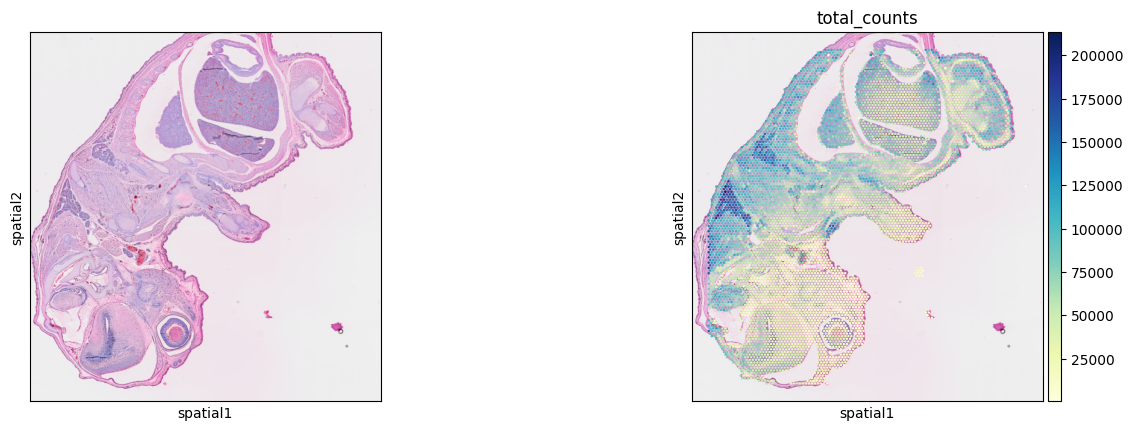

In [4]:
sc.pl.spatial(adata,
              color=[None, 'total_counts'],
              size=SPOT_SIZE,
              cmap='YlGnBu',
              img_key="hires",        
             )

## Preprocessing spatial data <a class="anchor" id="preprocessing-spatial-data"></a>

### Gene names

Although gene names in the form of ``gene symbols`` are preferred, scCellFie supports the ``ENSEMBL IDs`` as used as here in ``.var_names`` of this ``AnnData`` object, and internally convert them to the gene symbols, here under the name of ``feature_name``.

In [5]:
adata.var.head()

feature_id    feature_types genome  \
gene_ids                                                         
ENSMUSG00000051951  ENSMUSG00000051951  Gene Expression   mm10   
ENSMUSG00000025900  ENSMUSG00000025900  Gene Expression   mm10   
ENSMUSG00000025902  ENSMUSG00000025902  Gene Expression   mm10   
ENSMUSG00000025903  ENSMUSG00000025903  Gene Expression   mm10   
ENSMUSG00000033813  ENSMUSG00000033813  Gene Expression   mm10   

                    n_cells_by_counts  mean_counts  log1p_mean_counts  \
gene_ids                                                                
ENSMUSG00000051951                742     0.147187           0.137313   
ENSMUSG00000025900                440     0.073205           0.070649   
ENSMUSG00000025902               2614     0.852813           0.616705   
ENSMUSG00000025903               5205     4.515853           1.707626   
ENSMUSG00000033813               5652     6.649984           2.034703   

                    pct_dropout_by_counts  total_counts  log1p_total_counts  \
gene_ids                                                                      
ENSMUSG00000051951              88.467516         947.0            6.854354   
ENSMUSG00000025900              93.161330         471.0            6.156979   
ENSMUSG00000025902              59.372086        5487.0            8.610319   
ENSMUSG00000025903              19.101647       29055.0           10.276980   
ENSMUSG00000033813              12.154181       42786.0           10.663990   

                    n_cells feature_name  
gene_ids                                  
ENSMUSG00000051951      742         Xkr4  
ENSMUSG00000025900      440          Rp1  
ENSMUSG00000025902     2614        Sox17  
ENSMUSG00000025903     5205       Lypla1  
ENSMUSG00000033813     5652        Tcea1

(**Optional**) To work with gene symbols, we will replace the index names of ``adata.var`` with the column ``feature_name``. 

In [6]:
adata.var.set_index('feature_name', inplace=True)
adata.var.head()

feature_id    feature_types genome  n_cells_by_counts  \
feature_name                                                                  
Xkr4          ENSMUSG00000051951  Gene Expression   mm10                742   
Rp1           ENSMUSG00000025900  Gene Expression   mm10                440   
Sox17         ENSMUSG00000025902  Gene Expression   mm10               2614   
Lypla1        ENSMUSG00000025903  Gene Expression   mm10               5205   
Tcea1         ENSMUSG00000033813  Gene Expression   mm10               5652   

              mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
feature_name                                                          
Xkr4             0.147187           0.137313              88.467516   
Rp1              0.073205           0.070649              93.161330   
Sox17            0.852813           0.616705              59.372086   
Lypla1           4.515853           1.707626              19.101647   
Tcea1            6.649984           2.034703              12.154181   

              total_counts  log1p_total_counts  n_cells  
feature_name                                             
Xkr4                 947.0            6.854354      742  
Rp1                  471.0            6.156979      440  
Sox17               5487.0            8.610319     2614  
Lypla1             29055.0           10.276980     5205  
Tcea1              42786.0           10.663990     5652

### Raw counts

Raw counts are the inputs that scCellFie uses to internally perform all data processing that is needed. 

We start preparing `.X` to contain the raw count matrix:

In [7]:
adata.X = adata.layers['counts'].copy()

## Run scCellFie <a class="anchor" id="run-sccellfie"></a>

In current version, scCellFie supports `human` or `mouse` specific metabolic pathways. We will select `organism='mouse'` for the analysis.

In [8]:
results = sccellfie.run_sccellfie_pipeline(adata, 
                                           organism='mouse',
                                           sccellfie_data_folder=None,
                                           n_counts_col='total_counts', 
                                           process_by_group=False, 
                                           groupby=None, 
                                           neighbors_key='neighbors',
                                           n_neighbors=10, 
                                           batch_key=None, 
                                           threshold_key='sccellfie_threshold', 
                                           smooth_cells=True,
                                           alpha=0.33,
                                           chunk_size=5000,
                                           disable_pbar=False, 
                                           save_folder=None,
                                           save_filename=None
                                          )


==== scCellFie Pipeline: Initializing ====
Loading scCellFie database for organism: mouse

==== scCellFie Pipeline: Processing entire dataset ====

---- scCellFie Step: Preprocessing data ----

---- scCellFie Step: Computing neighbors ----


2025-05-10 12:43:36.638794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746881016.659355   13629 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746881016.665681   13629 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-10 12:43:36.697329: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



---- scCellFie Step: Preparing inputs ----
Gene names corrected to match database: 9
Shape of new adata object: (6434, 756)
Number of GPRs: 676
Shape of tasks by genes: (200, 756)
Shape of reactions by genes: (676, 756)
Shape of tasks by reactions: (200, 676)

---- scCellFie Step: Smoothing gene expression ----


Smoothing Expression: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]



---- scCellFie Step: Computing gene scores ----

---- scCellFie Step: Computing reaction activity ----


Cell Rxn Activities: 100%|██████████| 6434/6434 [00:53<00:00, 121.26it/s]



---- scCellFie Step: Computing metabolic task activity ----
Removed 1 metabolic tasks with zeros across all cells.

==== scCellFie Pipeline: Processing completed successfully ====


## Export results <a class="anchor" id="export-results"></a>

In [9]:
results.keys()

dict_keys(['adata', 'gpr_rules', 'task_by_gene', 'rxn_by_gene', 'task_by_rxn', 'rxn_info', 'task_info', 'thresholds', 'organism'])

To access metabolic activities, we need to inspect ``results['adata']``:

- The processed spatial data is located in the AnnData object ``results['adata']``.
- The reaction activities for each spot are located in the AnnData object ``results['adata'].reactions``.
- The metabolic task activities for each spot are located in the AnnData object ``results['adata'].metabolic_tasks``.

In particular:

- ``results['adata']``: contains gene expression in ``.X``.
- ``results['adata'].layers['gene_scores']``: contains gene scores as in the original CellFie paper.
- ``results['adata'].uns['Rxn-Max-Genes']``: contains determinant genes for each reaction per spot.
- ``results['adata'].reactions``: contains reaction scores in ``.X`` so every scanpy function can be used on this object to visualize or compare values.
- ``results['adata'].metabolic_tasks``: contains metabolic task scores in ``.X`` so every scanpy function can be used on this object to visualize or compare values.

Other keys in the ``results`` dictionary are associated with the scCellFie database and are already filtered for the elements present
in the dataset (``'gpr_rules'``, ``'task_by_gene'``, ``'rxn_by_gene'``, ``'task_by_rxn'``, ``'rxn_info'``, ``'task_info'``, ``'thresholds'``, ``'organism'``).

### Save spatial results

We can save our spatial results contained in the AnnData objects (``results['adata']``) into a specific folder. Here we only need to specify the output folder, and the basename that our AnnData objects will have. This function below saves the expression object (``results['adata']``) and those containing scores for reactions and metabolic tasks (``results['adata'].reactions`` and ``results['adata'].metabolic_tasks``, respectively), as separate files.

In [10]:
sccellfie.io.save_adata(adata=results['adata'], output_directory='./results', filename='Mouse_Spatial_scCellFie')

./results/Mouse_Spatial_scCellFie.h5ad was correctly saved
./results/Mouse_Spatial_scCellFie_reactions.h5ad was correctly saved
./results/Mouse_Spatial_scCellFie_metabolic_tasks.h5ad was correctly saved


## Spatial visualization <a class="anchor" id="spatial-visualization"></a>


scCellFie implements multiple visualizations, including plots to see metabolic activity across tissues.

In this case, we first define metabolic tasks that may be important for early stages of development:

In [11]:
development = [
    'ATP generation from glucose (hypoxic conditions) - glycolysis',
    'Conversion of histidine to histamine',
    'O-linked glycosylation',
    'CMP-N-acetylneuraminate synthesis',
    'Conversion of estrone (E1) to estradiol-17beta (E2)',
    'Synthesis of inositol',
    'Conversion of 1-phosphatidyl-1D-myo-inositol 4,5-bisphosphate to 1D-myo-inositol 1,4,5-trisphosphate',
    'Synthesis of GABA',
    'Reactive oxygen species detoxification (H2O2 to H2O)',
    'S-adenosyl-L-methionine synthesis'
]

Then, we use a scCellFie plotting function to visualize them in space:

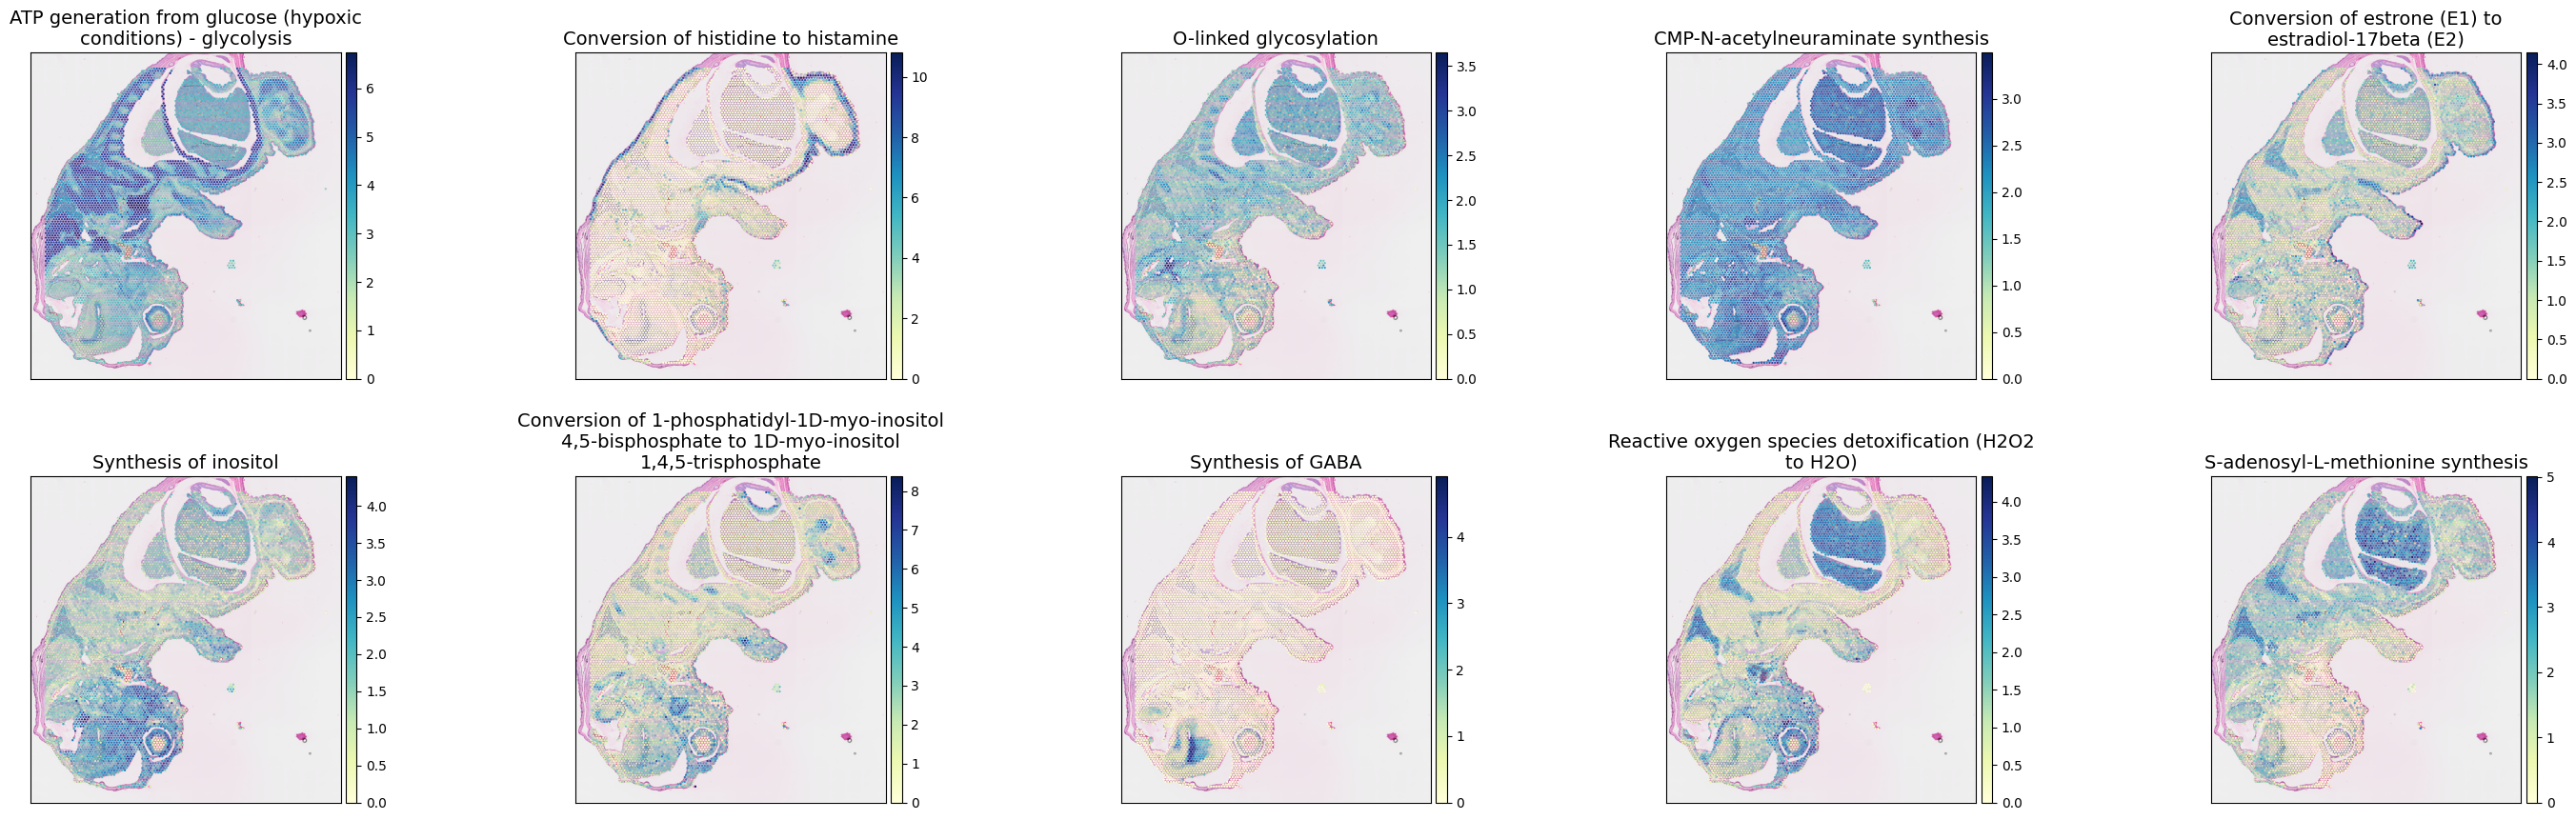

In [12]:
fig, axes = sccellfie.plotting.plot_spatial(results['adata'].metabolic_tasks,
                                            keys=development , 
                                            img_key='hires',
                                            cmap='YlGnBu',
                                            size=SPOT_SIZE,
                                            use_raw=False, 
                                            ncols=5,
                                            hspace=0.3,
                                            vmin=0
                                            )

## Identification of metabolic markers <a class="anchor" id="identification-of-metabolic-markers"></a>

To identify markers, we can use different approaches. Here we show an approach based on [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), which comes from the Natural Language Processing field, and the [logistic regression implemented in Scanpy](https://www.nature.com/articles/s41592-018-0303-9).

### Defining annotated regions for the selection of markers

To select markers, we need to define region annotations so the algorithms can focus on enriched activities in those annotations.

As a demonstration, we will perform simple unsupervised clustering to define regional features of the whole embryo.

In [13]:
sadata = adata.copy()
sc.pp.normalize_total(sadata, target_sum=1e4)
sc.pp.log1p(sadata)
sc.pp.highly_variable_genes(sadata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sadata = sadata[:, sadata.var.highly_variable]
sc.tl.pca(sadata, svd_solver='arpack')
sc.pp.neighbors(sadata, n_neighbors=10, n_pcs=40)
sc.tl.umap(sadata)
sc.tl.leiden(sadata, resolution=0.4)

Then, we assign these annotations to our AnnData objects in under `results['adata']` to help with further analyses and visualizations

In [14]:
results['adata'].obs[ANNOTATION] = sadata.obs['leiden']
results['adata'].reactions.obs[ANNOTATION] = sadata.obs['leiden']
results['adata'].metabolic_tasks.obs[ANNOTATION] = sadata.obs['leiden']

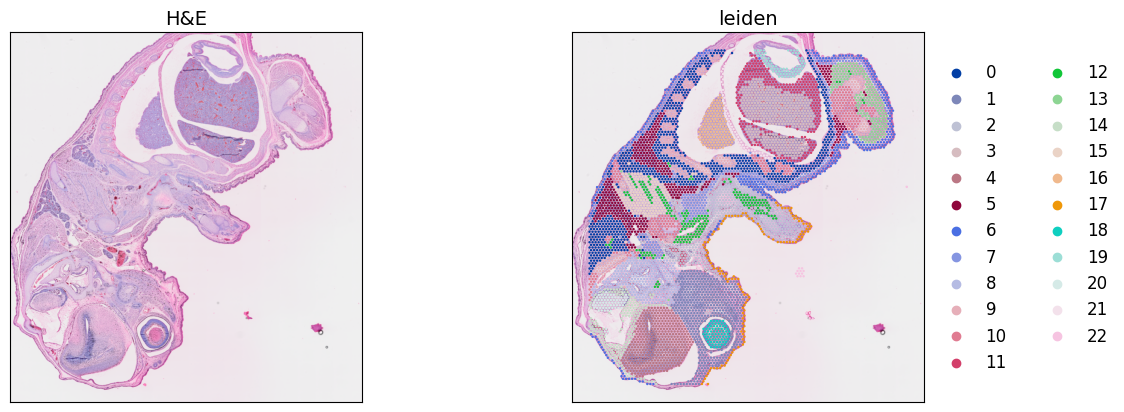

In [15]:
fig, axes = sccellfie.plotting.plot_spatial(results['adata'],
                                            keys=[None, ANNOTATION],
                                            img_key='hires',
                                            cmap='YlGnBu',
                                            size=SPOT_SIZE ,
                                            use_raw=False, 
                                            ncols=2, 
                                            dpi=DPI
                                            )

### Marker detection using TF-IDF

scCellFie implements a TF-IDF (Term Frequency-Inverse Document Frequency) approach, adapted from the SoupX tool in R. 

We define `express_cut=5*np.log(2)` to determine which spots are expressing each metabolic task. This value (`5*np.log(2)`) indicates that all reactions in the task are over the threshold value of the determinant gene (or "active").

In [16]:
mrks = sccellfie.external.quick_markers(results['adata'].metabolic_tasks,
                                        cluster_key=ANNOTATION,
                                        n_markers=20,
                                        express_cut=5*np.log(2))

In [17]:
mrks.head()

gene cluster        tf       idf    tf_idf  \
0                 Glycogen degradation       0  0.905195  1.592333  1.441372   
1  Hydroxymethylglutaryl-CoA synthesis       0  0.802597  1.750950  1.405308   
2               Acetoacetate synthesis       0  0.709091  1.884865  1.336541   
3                 Synthesis of acetone       0  0.709091  1.884865  1.336541   
4  Synthesis of creatine from arginine       0  0.990909  1.241558  1.230271   

   gene_frequency_outside_cluster  gene_frequency_global  second_best_tf  \
0                        0.108051               0.203450        0.942529   
1                        0.088100               0.173609        0.919540   
2                        0.076095               0.151850        0.850575   
3                        0.076095               0.151850        0.850575   
4                        0.193503               0.288934        0.994253   

  second_best_cluster  pval  qval  
0                  15   0.0   0.0  
1                  15   0.0   0.0  
2                  15   0.0   0.0  
3                  15   0.0   0.0  
4                  15   0.0   0.0

By examining the distributions of TF-IDF scores, we can filter the results to identify more specific tasks:

<Axes: >

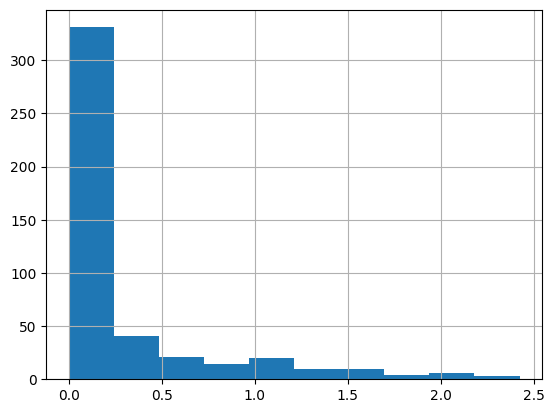

In [18]:
mrks['tf_idf'].hist()

Text(0, 0.5, 'IDF')

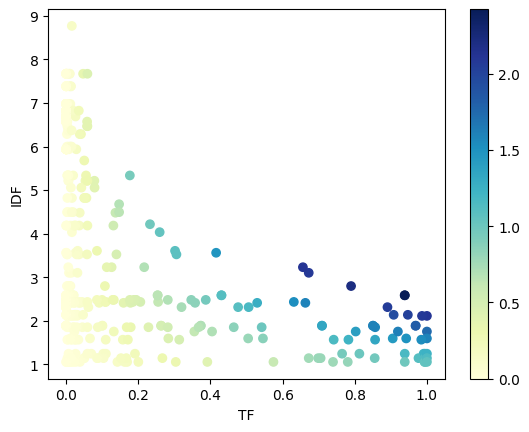

In [19]:
# Scatter plot of TF vs IDF with TF-IDF as color
scatter = plt.scatter(mrks['tf'], mrks['idf'], c=mrks['tf_idf'], cmap='YlGnBu')
plt.colorbar(scatter)
plt.xlabel('TF')
plt.ylabel('IDF')

scCellFie includes a filtering function that fits a hyperbolic curve, while the user can define some thresholds based on the tf-idf scores, and the ratio between the top and second best clusters (`tf_ratio`).

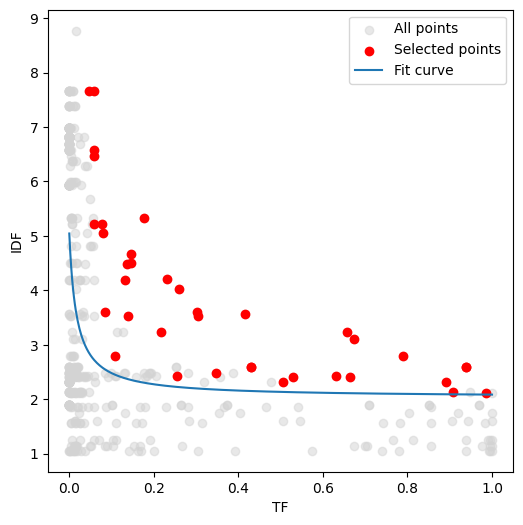

In [20]:
x_col = 'tf'
y_col = 'idf'
df = mrks
tfidf_threshold = 0.3
tf_ratio = 1.2

# Visualization
plt.figure(figsize=(6, 6))
# Plot all points
plt.scatter(df[x_col], df[y_col], alpha=0.5, c='lightgray', label='All points')
# Plot selected points
filtered_mrks, curve = sccellfie.external.filter_tfidf_markers(df, tf_col=x_col, idf_col=y_col, 
                                                              tfidf_threshold=tfidf_threshold, 
                                                              tf_ratio=tf_ratio)
plt.scatter(filtered_mrks[x_col], filtered_mrks[y_col], c='red', label='Selected points')
plt.plot(*curve, label='Fit curve')
plt.xlabel('TF')
plt.ylabel('IDF')
plt.legend()

A detailed list of the selected markers:

In [21]:
filtered_mrks

gene cluster        tf  \
21                             Ethanol to acetaldehyde       1  0.130841   
24                             UDP-galactose synthesis       1  0.057944   
41                      Glycerol-3-phosphate synthesis       2  0.107356   
62                   S-adenosyl-L-methionine synthesis       3  0.301762   
63            Homocysteine synthesis (need methionine)       3  0.136564   
80                             Degradation of cytosine       4  0.938497   
81                               Degradation of uracil       4  0.938497   
100                     Glycerol-3-phosphate synthesis       5  0.789731   
101                      Krebs cycle - NADH generation       5  0.672372   
102                      Gluconeogenesis from Glycerol       5  0.415648   
104  Synthesis of fructose-6-phosphate from erythro...       5  0.305623   
105                                  Glycine synthesis       5  0.259169   
106                                     Heme synthesis       5  0.232274   
109                             Methionine degradation       5  0.146699   
110                                   Serine synthesis       5  0.146699   
120               Conversion of histidine to histamine       6  0.663043   
149                       Gluconeogenesis from Lactate       7  0.216301   
160                 Synthesis of taurine from cysteine       8  0.254839   
180                 Synthesis of taurine from cysteine       9  0.631068   
200             UDP-N-acetyl D-galactosamine synthesis      10  0.078689   
220                             Synthesis of bilirubin      11  0.986348   
221               Conversion of asparate to asparagine      11  0.907850   
222                  S-adenosyl-L-methionine synthesis      11  0.085324   
306                   (R)-3-Hydroxybutanoate synthesis      15  0.505747   
342  Conversion of estrone (E1) to estradiol-17beta...      17  0.057971   
343     Synthesis of testosterone from androstenedione      17  0.057971   
360                            Degradation of cytosine      18  0.430380   
361                              Degradation of uracil      18  0.430380   
363  Synthesis of fructose-6-phosphate from erythro...      18  0.139241   
380  Conversion of 1-phosphatidyl-1D-myo-inositol 4...      19  0.346667   
420                       Gluconeogenesis from Lactate      21  0.656250   
421                   (R)-3-Hydroxybutanoate synthesis      21  0.890625   
430                      Gluconeogenesis from pyruvate      21  0.078125   
431                              UDP-glucose synthesis      21  0.046875   
440               Conversion of histidine to histamine      22  0.529412   
441    Synthesis of phosphatidylinositol from inositol      22  0.176471   
442                  Conversion of glycine to pyruvate      22  0.058824   

          idf    tf_idf  gene_frequency_outside_cluster  \
21   4.184384  0.547490                        0.004747   
24   5.214004  0.302120                        0.000678   
41   2.795542  0.300118                        0.057157   
62   3.604566  1.087721                        0.006355   
63   4.478892  0.611655                        0.001839   
80   2.583143  2.424271                        0.012344   
81   2.583143  2.424271                        0.012344   
100  2.795542  2.207726                        0.011618   
101  3.099471  2.083996                        0.002490   
102  3.559866  1.479651                        0.002158   
104  3.522328  1.076506                        0.010788   
105  4.033153  1.045267                        0.001328   
106  4.215475  0.979145                        0.000000   
109  4.675007  0.685820                        0.000000   
110  4.492686  0.659074                        0.001992   
120  2.409778  1.597787                        0.055061   
149  3.228088  0.698239                        0.030417   
160  2.430758  0.619451                        0.079523   
180  2.430758  1.533973                 

Finally, we will get the unique list of filtered markers

In [22]:
tf_idf_mrks = filtered_mrks['gene'].unique().tolist()
len(tf_idf_mrks)

28

In [23]:
tf_idf_mrks

['Ethanol to acetaldehyde',
 'UDP-galactose synthesis',
 'Glycerol-3-phosphate synthesis',
 'S-adenosyl-L-methionine synthesis',
 'Homocysteine synthesis (need methionine)',
 'Degradation of cytosine',
 'Degradation of uracil',
 'Krebs cycle - NADH generation',
 'Gluconeogenesis from Glycerol',
 'Synthesis of fructose-6-phosphate from erythrose-4-phosphate (HMP shunt)',
 'Glycine synthesis',
 'Heme synthesis',
 'Methionine degradation',
 'Serine synthesis',
 'Conversion of histidine to histamine',
 'Gluconeogenesis from Lactate',
 'Synthesis of taurine from cysteine',
 'UDP-N-acetyl D-galactosamine synthesis',
 'Synthesis of bilirubin',
 'Conversion of asparate to asparagine',
 '(R)-3-Hydroxybutanoate synthesis',
 'Conversion of estrone (E1) to estradiol-17beta (E2)',
 'Synthesis of testosterone from androstenedione',
 'Conversion of 1-phosphatidyl-1D-myo-inositol 4,5-bisphosphate to 1D-myo-inositol 1,4,5-trisphosphate',
 'Gluconeogenesis from pyruvate',
 'UDP-glucose synthesis',
 'Syn

### Detection using Logistic Regression in Scanpy

We can also use logistic regression, as implemented in Scanpy, to identify metabolic task markers:

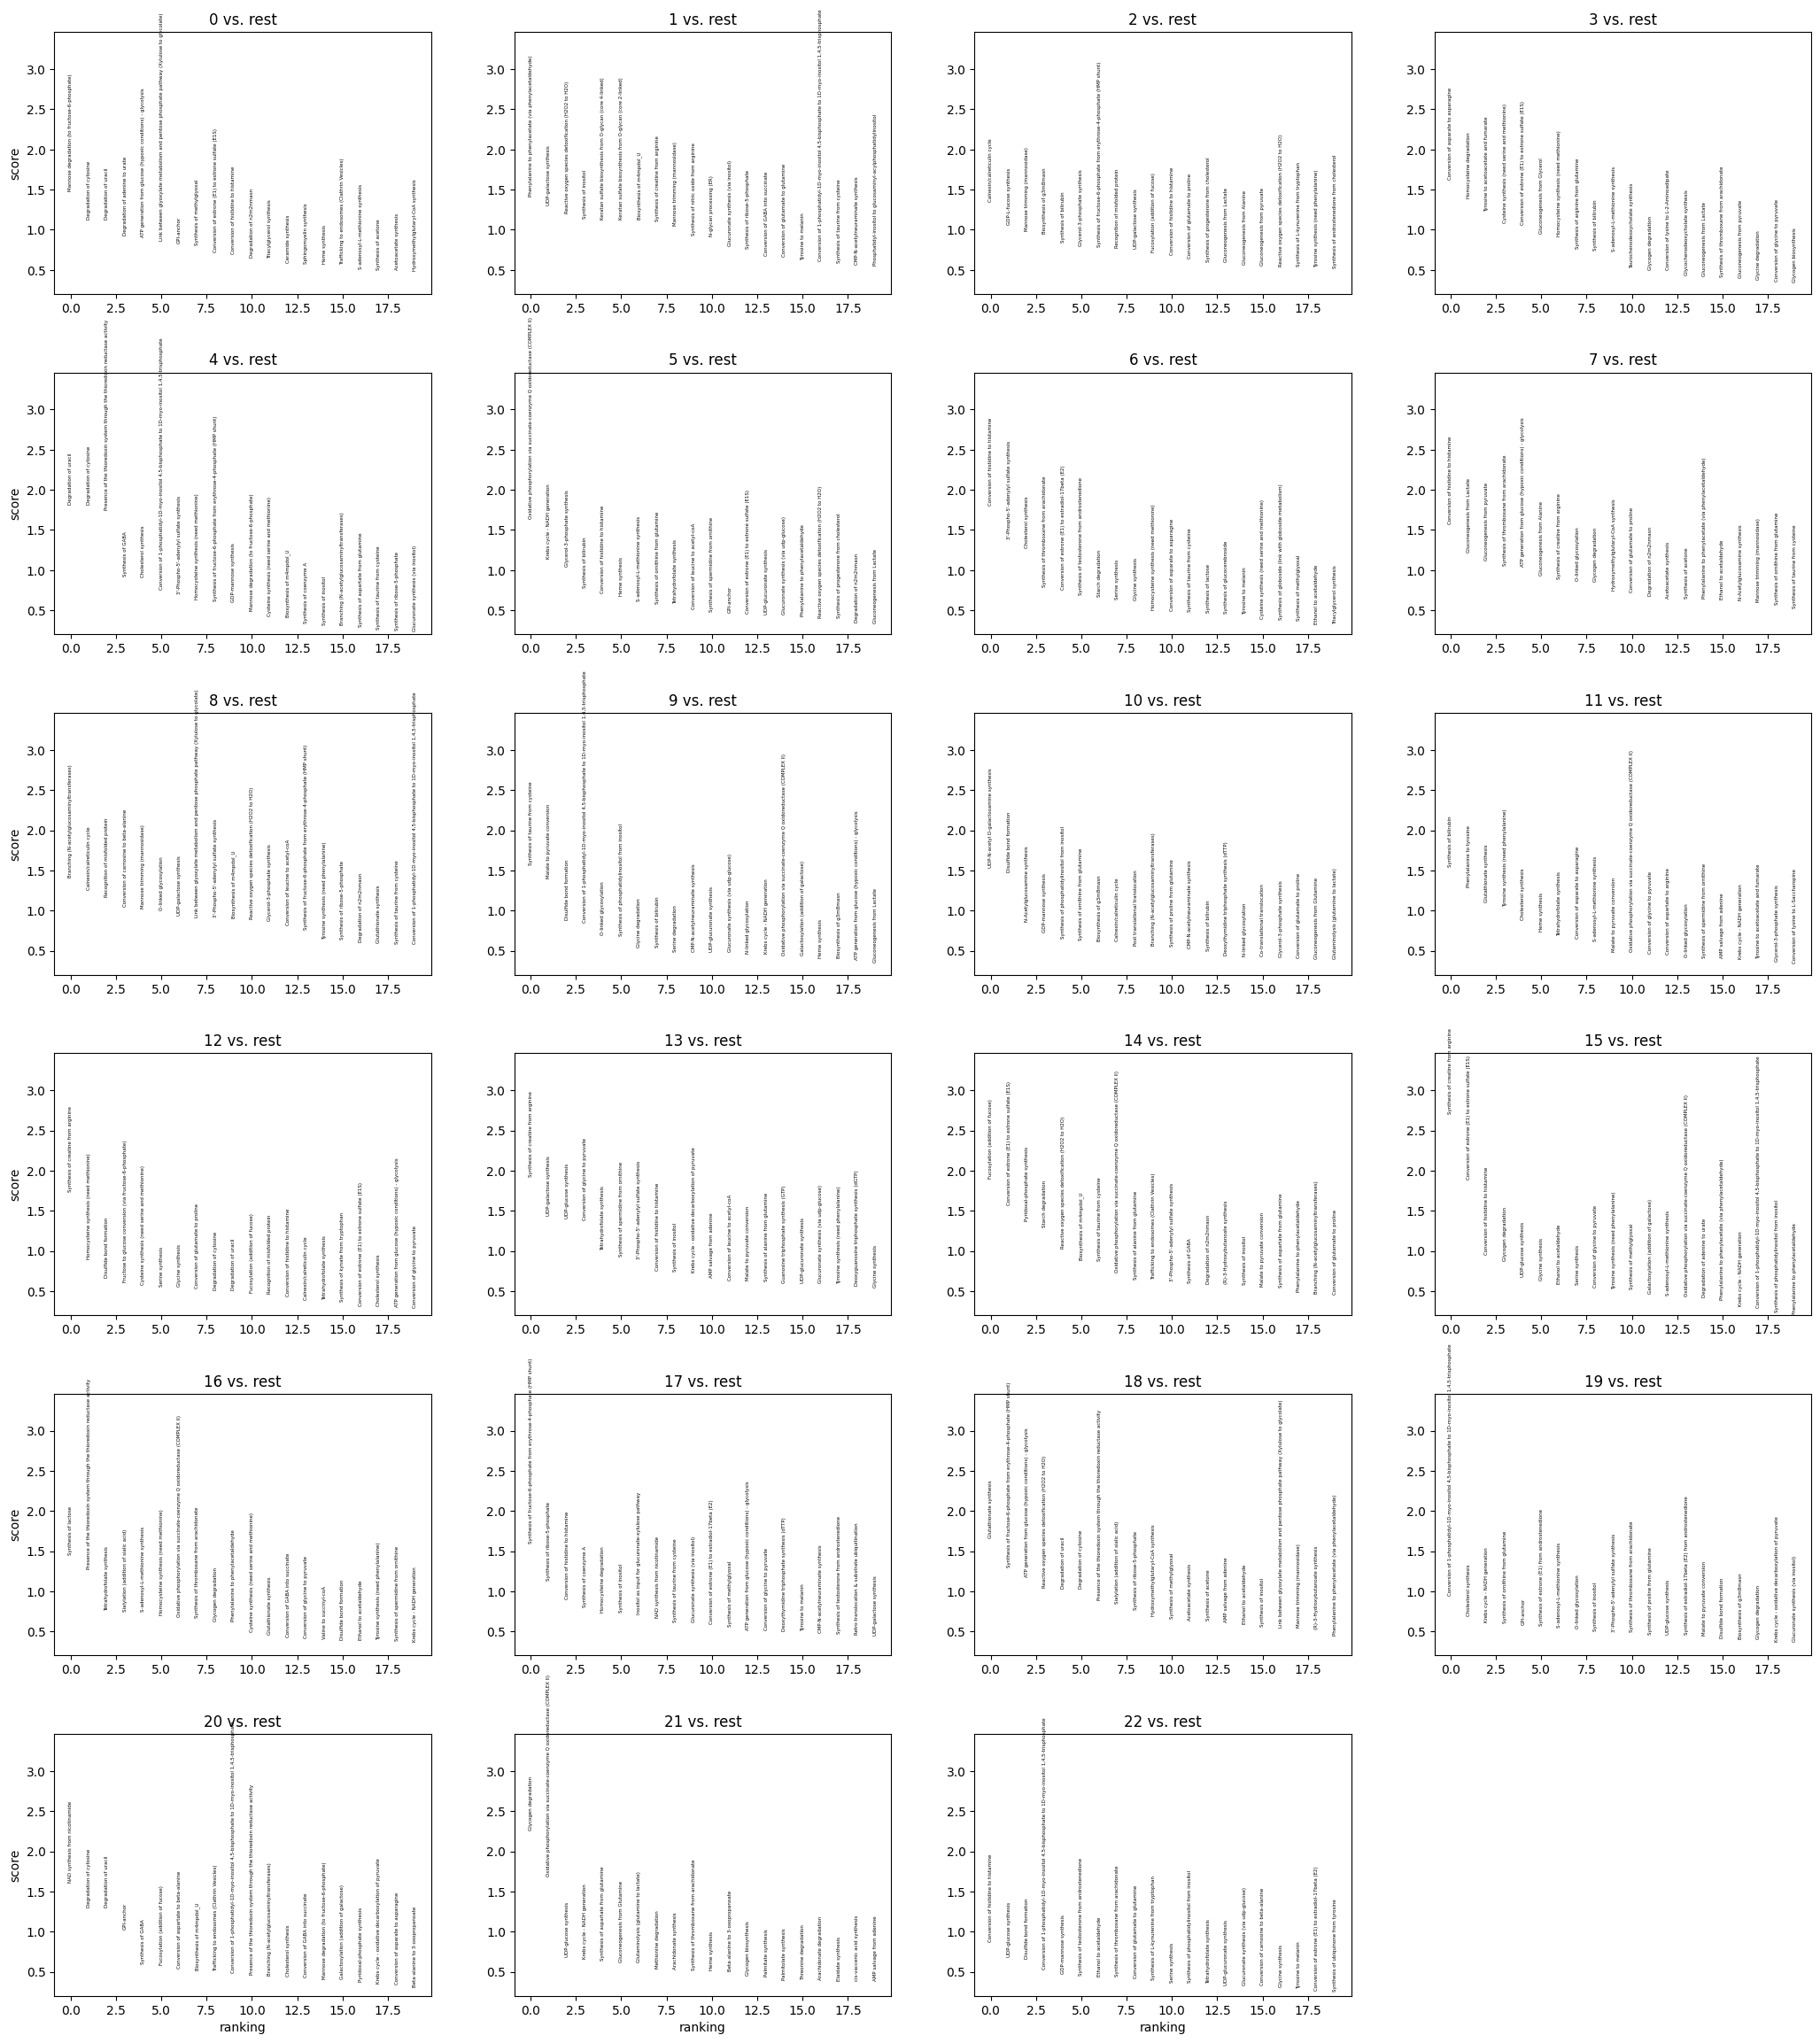

In [24]:
method = 'logreg'
sc.tl.rank_genes_groups(results['adata'].metabolic_tasks, groupby=ANNOTATION, method=method,
                       use_raw=False, key_added=method)
sc.pl.rank_genes_groups(results['adata'].metabolic_tasks, n_genes=20, sharey=True, key=method, fontsize=4)

Extract the result in a dataframe

In [25]:
scanpy_df = sc.get.rank_genes_groups_df(results['adata'].metabolic_tasks, 
                                        key=method, 
                                        group=None) 

scanpy_df.head()

group                                              names    scores
0     0      Mannose degradation (to fructose-6-phosphate)  1.480771
1     0                            Degradation of cytosine  1.127286
2     0                              Degradation of uracil  1.127286
3     0                    Degradation of adenine to urate  0.926927
4     0  ATP generation from glucose (hypoxic condition...  0.905349

We can filter the logistic regression markers based on their scores:

<Axes: >

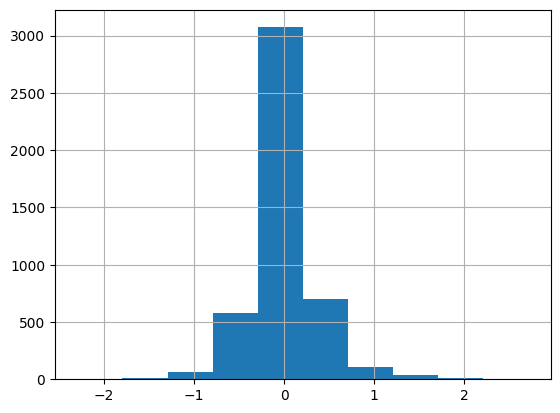

In [26]:
scanpy_df['scores'].hist()

In [27]:
# Filter based on score threshold
scores_threshold = 1.5
filtered_scanpy_mrks = scanpy_df.loc[scanpy_df['scores'] > scores_threshold]

In [28]:
filtered_scanpy_mrks

group                                              names    scores
597      3               Conversion of asparate to asparagine  1.626031
796      4                              Degradation of uracil  1.820949
797      4                            Degradation of cytosine  1.820949
798      4  Presence of the thioredoxin system through the...  1.747238
995      5  Oxidative phosphorylation via succinate-coenzy...  1.639906
1194     6               Conversion of histidine to histamine  1.805179
1393     7               Conversion of histidine to histamine  1.569943
1791     9                 Synthesis of taurine from cysteine  1.565231
1990    10             UDP-N-acetyl D-galactosamine synthesis  1.535176
2189    11                             Synthesis of bilirubin  1.540485
2388    12                Synthesis of creatine from arginine  1.737556
2587    13                Synthesis of creatine from arginine  1.926244
2786    14                  Fucosylation (addition of fucose)  1.906202
2787    14  Conversion of estrone (E1) to estrone sulfate ...  1.570353
2985    15                Synthesis of creatine from arginine  2.710084
2986    15  Conversion of estrone (E1) to estrone sulfate ...  1.896867
3383    17  Synthesis of fructose-6-phosphate from erythro...  1.597093
3582    18                            Glutathionate synthesis  1.662967
3980    20                    NAD synthesis from nicotinamide  1.608922
4179    21                               Glycogen degradation  2.259699
4180    21  Oxidative phosphorylation via succinate-coenzy...  1.691183

In [29]:
# Convert them to a list
scanpy_mrks = filtered_scanpy_mrks['names'].unique().tolist()
len(scanpy_mrks)

16

#### Combining TF-IDF & Logistic Regression Markers

We can combine the metabolic tasks from different approaches:

In [32]:
both_markers = sorted(set(tf_idf_mrks).union(set(scanpy_mrks)))
len(both_markers)

36

### Select only highly active markers

We can filter the markers based on their activity level by aggregating the metabolic activity to the cell-type level. Here, we consider only metabolic tasks with a prudent score at the cluster level (`` > 1 ``)

In [33]:
agg = sccellfie.expression.aggregation.agg_expression_cells(results['adata'].metabolic_tasks[:, both_markers], 
                                                            ANNOTATION, 
                                                            agg_func='trimean')
agg = agg.T.loc[(agg.T > 1.).any(axis=1)]

both_markers = agg.index.tolist()

Then we can visualize them in space:

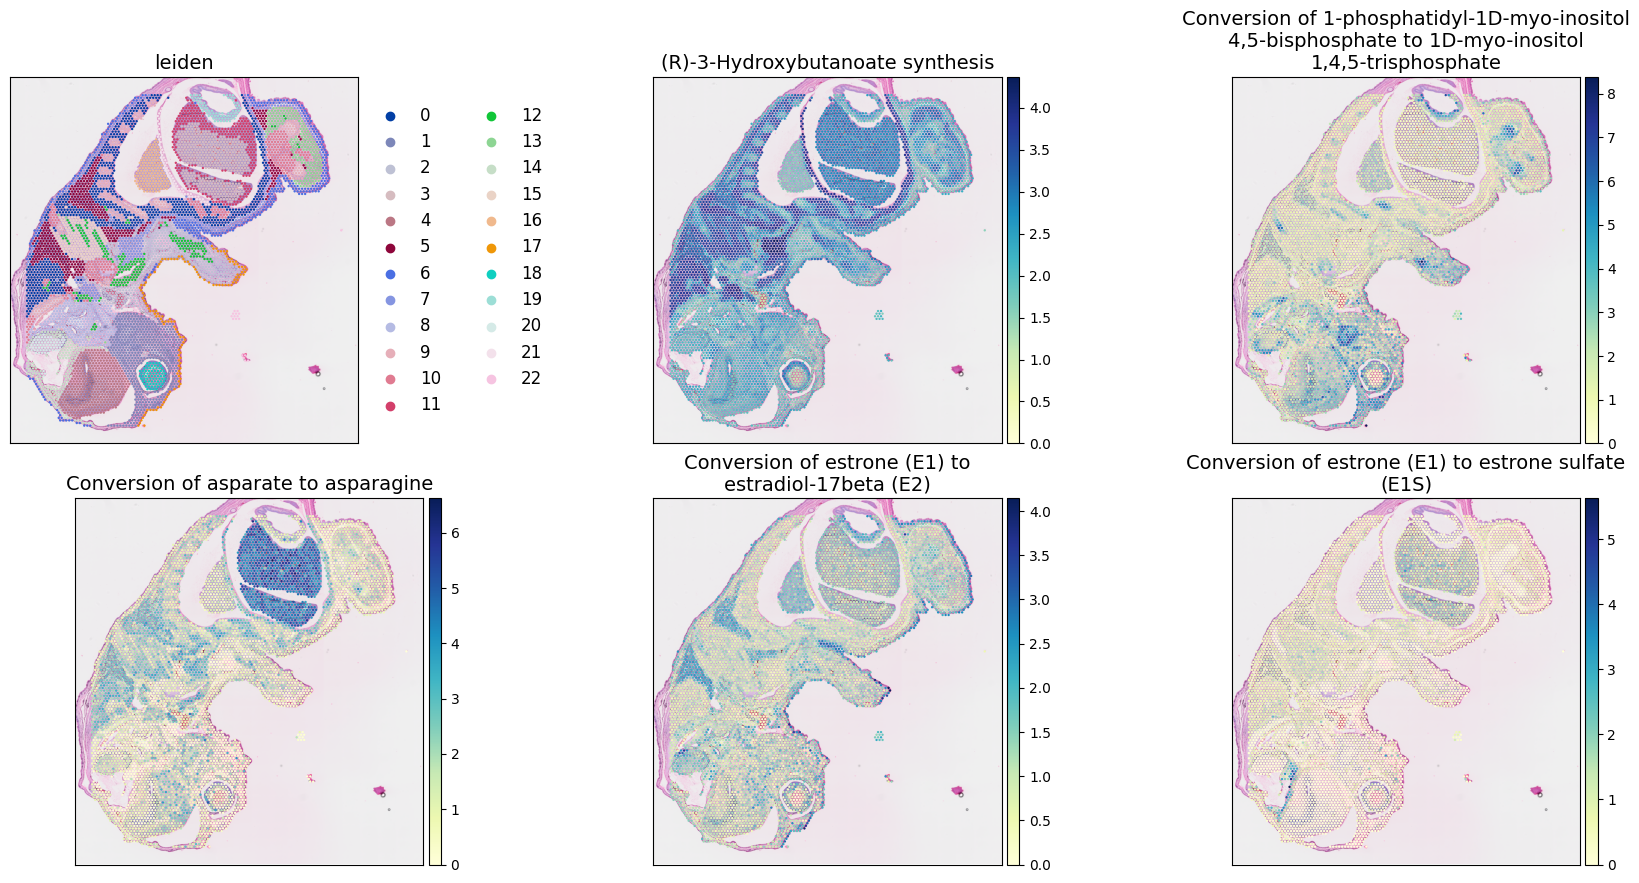

In [34]:
## visualise only 5 markers due to notebook size
fig, axes = sccellfie.plotting.plot_spatial(results['adata'].metabolic_tasks,
                                            keys=[ANNOTATION] + both_markers[0:5],
                                            img_key='hires',
                                            cmap='YlGnBu',
                                            size=SPOT_SIZE,
                                            use_raw=False, 
                                            ncols=3,
                                            vmin=0  
                                            )

## Spatial patterns <a class="anchor" id="spatial-patterns"></a>


scCellFie supports multiple algorithms to identify patterns across space, including the analysis of hotspots, assortativity, and autocorrelation (Moran's I).

To illustrate the identification of spatial patterns, in this tutorial we will use the autocorrelation approach.

### Generate spatial knn network

Methods to identify spatial patterns often rely on spatial neighbors, so we start computing our KNN network based on spatial locations. We compute this network in our original AnnData object and the one containing the metabolic scores for each task, in this case based on the 10-nearest neighbors:

In [35]:
sccellfie.spatial.create_knn_network(adata, n_neighbors=10, spatial_key='spatial')

In [36]:
sccellfie.spatial.create_knn_network(results['adata'].metabolic_tasks, n_neighbors=10, spatial_key='spatial')

### Computing autocorrelation (Moran's I coefficient)

**Moran's I** is a measure of **spatial autocorrelation**, which quantifies how similar a variable is to itself in nearby spatial locations. In the context of spatial transcriptomics, where each spot or cell has a spatial coordinate and, here, an inferred **metabolic activity score**, Moran’s I can identify whether these scores are spatially clustered (positive autocorrelation), dispersed (negative autocorrelation), or randomly distributed (no autocorrelation).

Let:  
- ($ x_i $) be the metabolic activity score at spatial location ($ i $),  
- \($ \bar{x} $\) be the mean metabolic activity across all locations,  
- \($ w_{ij} $\) be the spatial weight between location \($ i $\) and \($ j $\) (e.g., inverse distance or adjacency),  
- \($ N $\) be the total number of spatial locations.

Then **Moran's I** is computed as:

$$
I = \frac{N}{W} \cdot \frac{\sum_{i=1}^{N} \sum_{j=1}^{N} w_{ij} (x_i - \bar{x})(x_j - \bar{x})}{\sum_{i=1}^{N} (x_i - \bar{x})^2}
$$

where:

$$
W = \sum_{i=1}^{N} \sum_{j=1}^{N} w_{ij}
$$

**Interpretation:**
- \( I > 0 \): **Positive spatial autocorrelation** (similar metabolic activities cluster spatially).  
- \( I < 0 \): **Negative spatial autocorrelation** (dissimilar metabolic activities are near each other).  
- \( I $ \approx $ 0 \): **No spatial autocorrelation** (random spatial distribution).

In [37]:
sq.gr.spatial_autocorr(
    results['adata'].metabolic_tasks,
    mode="moran",
    n_perms=1000,
    n_jobs=1,
)

  0%|          | 0/1000 [00:00<?, ?/s]

In [38]:
moran = results['adata'].metabolic_tasks.uns['moranI']

In [39]:
moran

I  pval_norm  \
Heme synthesis                                      0.943502        0.0   
Tyrosine to acetoacetate and fumarate               0.931207        0.0   
Synthesis of bilirubin                              0.918218        0.0   
Synthesis of globoside (link with globoside met...  0.912165        0.0   
Synthesis of glucocerebroside                       0.908566        0.0   
...                                                      ...        ...   
Synthesis of anthranilate from tryptophan           0.243993        0.0   
Synthesis of L-kynurenine from tryptophan           0.177245        0.0   
GDP-L-fucose synthesis                              0.165651        0.0   
Phosphatidyl-inositol to glucosaminyl-acylphosp...  0.155917        0.0   
Conversion of glutamate to glutamine                0.136900        0.0   

                                                    var_norm  pval_z_sim  \
Heme synthesis                                      0.000057         0.0   
Tyrosine to acetoacetate and fumarate               0.000057         0.0   
Synthesis of bilirubin                              0.000057         0.0   
Synthesis of globoside (link with globoside met...  0.000057         0.0   
Synthesis of glucocerebroside                       0.000057         0.0   
...                                                      ...         ...   
Synthesis of anthranilate from tryptophan           0.000057         0.0   
Synthesis of L-kynurenine from tryptophan           0.000057         0.0   
GDP-L-fucose synthesis                              0.000057         0.0   
Phosphatidyl-inositol to glucosaminyl-acylphosp...  0.000057         0.0   
Conversion of glutamate to glutamine                0.000057         0.0   

                                                    pval_sim   var_sim  \
Heme synthesis                                      0.000999  0.000154   
Tyrosine to acetoacetate and fumarate               0.000999  0.000147   
Synthesis of bilirubin                              0.000999  0.000150   
Synthesis of globoside (link with globoside met...  0.000999  0.000147   
Synthesis of glucocerebroside                       0.000999  0.000147   
...                                                      ...       ...   
Synthesis of anthranilate from tryptophan           0.000999  0.000063   
Synthesis of L-kynurenine from tryptophan           0.000999  0.000054   
GDP-L-fucose synthesis                              0.000999  0.000044   
Phosphatidyl-inositol to glucosaminyl-acylphosp...  0.000999  0.000046   
Conversion of glutamate to glutamine                0.000999  0.000046   

                                                    pval_norm_fdr_bh  \
Heme synthesis                                                   0.0   
Tyrosine to acetoacetate and fumarate                            0.0   
Synthesis of bilirubin                                           0.0   
Synthesis of globoside (link with globoside met...               0.0   
Synthesis of glucocerebroside                                    0.0   
...                                                              ...   
Synthesis of anthranilate from tryptophan                        0.0   
Synthesis of L-kynurenine from tryptophan                        0.0   
GDP-L-fucose synthesis                                           0.0   
Phosphatidyl-inositol to glucosaminyl-acylphosp...               0.0   
Conversion of glutamate to glutamine                             0.0   

                                                    pval_z_sim_fdr_bh  \
Heme synthesis                                                    0.0   
Tyrosine to acetoacetate and fumarate                             0.0   
Synthesis of bilirubin                                            0.0   
Synthesis of globoside (link with globoside met...                0.0   
Synthesis of glucocerebroside                                     0.0   
...                                                  

#### Visualize spatially informative variables (High Moran's I coefficient)

<Axes: >

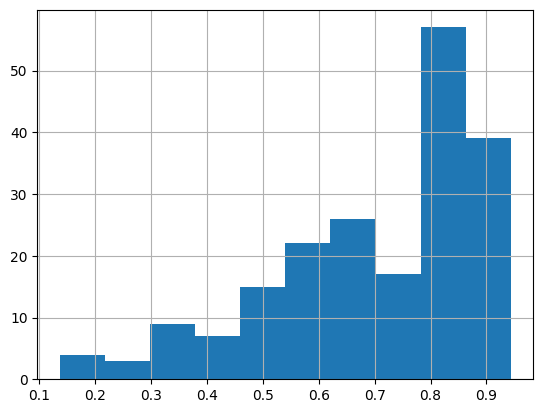

In [40]:
moran['I'].hist()

We can set a threshold to select highly autocorrelated featurres, in this case we use a Moran's I of at least 0.6

In [47]:
coef_threshold = 0.6

In [48]:
top_moran = moran[moran['I'].abs() >= coef_threshold].dropna().sort_values(by='I', ascending=False)

In [49]:
top_moran

I  pval_norm  \
Heme synthesis                                      0.943502        0.0   
Tyrosine to acetoacetate and fumarate               0.931207        0.0   
Synthesis of bilirubin                              0.918218        0.0   
Synthesis of globoside (link with globoside met...  0.912165        0.0   
Synthesis of glucocerebroside                       0.908566        0.0   
...                                                      ...        ...   
Inosine monophosphate synthesis (IMP)               0.609340        0.0   
Degradation of n2m2nmasn                            0.608268        0.0   
N-glycan processing (ER)                            0.604972        0.0   
Deoxyadenosine triphosphate synthesis (dATP)        0.604090        0.0   
Deoxycytidine triphosphate synthesis (dCTP)         0.600372        0.0   

                                                    var_norm  pval_z_sim  \
Heme synthesis                                      0.000057         0.0   
Tyrosine to acetoacetate and fumarate               0.000057         0.0   
Synthesis of bilirubin                              0.000057         0.0   
Synthesis of globoside (link with globoside met...  0.000057         0.0   
Synthesis of glucocerebroside                       0.000057         0.0   
...                                                      ...         ...   
Inosine monophosphate synthesis (IMP)               0.000057         0.0   
Degradation of n2m2nmasn                            0.000057         0.0   
N-glycan processing (ER)                            0.000057         0.0   
Deoxyadenosine triphosphate synthesis (dATP)        0.000057         0.0   
Deoxycytidine triphosphate synthesis (dCTP)         0.000057         0.0   

                                                    pval_sim   var_sim  \
Heme synthesis                                      0.000999  0.000154   
Tyrosine to acetoacetate and fumarate               0.000999  0.000147   
Synthesis of bilirubin                              0.000999  0.000150   
Synthesis of globoside (link with globoside met...  0.000999  0.000147   
Synthesis of glucocerebroside                       0.000999  0.000147   
...                                                      ...       ...   
Inosine monophosphate synthesis (IMP)               0.000999  0.000090   
Degradation of n2m2nmasn                            0.000999  0.000101   
N-glycan processing (ER)                            0.000999  0.000089   
Deoxyadenosine triphosphate synthesis (dATP)        0.000999  0.000090   
Deoxycytidine triphosphate synthesis (dCTP)         0.000999  0.000099   

                                                    pval_norm_fdr_bh  \
Heme synthesis                                                   0.0   
Tyrosine to acetoacetate and fumarate                            0.0   
Synthesis of bilirubin                                           0.0   
Synthesis of globoside (link with globoside met...               0.0   
Synthesis of glucocerebroside                                    0.0   
...                                                              ...   
Inosine monophosphate synthesis (IMP)                            0.0   
Degradation of n2m2nmasn                                         0.0   
N-glycan processing (ER)                                         0.0   
Deoxyadenosine triphosphate synthesis (dATP)                     0.0   
Deoxycytidine triphosphate synthesis (dCTP)                      0.0   

                                                    pval_z_sim_fdr_bh  \
Heme synthesis                                                    0.0   
Tyrosine to acetoacetate and fumarate                             0.0   
Synthesis of bilirubin                                            0.0   
Synthesis of globoside (link with globoside met...                0.0   
Synthesis of glucocerebroside                                     0.0   
...                                                  

In [50]:
spa_informative_var = list(top_moran.index)

Then, we can further filter top metabolic tasks to pick those with a high activity in at least one Visium spot

In [51]:
mt_df = results['adata'].metabolic_tasks.to_df().max(axis=0)
spa_informative_var = list(mt_df[spa_informative_var][mt_df[spa_informative_var] > 5*np.log(2)].index)

In [52]:
spa_informative_var

['Heme synthesis',
 'Synthesis of bilirubin',
 'Homocysteine degradation',
 'Krebs cycle - NADH generation',
 'Degradation of uracil',
 'Degradation of cytosine',
 'Methionine degradation',
 'Cysteine synthesis (need serine and methionine)',
 'Gluconeogenesis from Glycerol',
 'Glycerol-3-phosphate synthesis',
 'Oxidative phosphorylation via succinate-coenzyme Q oxidoreductase (COMPLEX II)',
 'Gluconeogenesis from pyruvate',
 'Phenylalanine to tyrosine',
 'Gluconeogenesis from Lactate',
 'Synthesis of GABA',
 'Glutathionate synthesis',
 'Reactive oxygen species detoxification (H2O2 to H2O)',
 'Synthesis of creatine from arginine',
 'Synthesis of malonyl-coa',
 'Synthesis of acetone',
 'Acetoacetate synthesis',
 'ATP generation from glucose (hypoxic conditions) - glycolysis',
 'Hydroxymethylglutaryl-CoA synthesis',
 'Glycogen degradation',
 'Glycine synthesis',
 'Conversion of asparate to asparagine',
 'Homocysteine synthesis (need methionine)',
 'Synthesis of methylglyoxal',
 '(R)-3-Hyd

Finally, we can visualize them in space to observe the patterns they have:

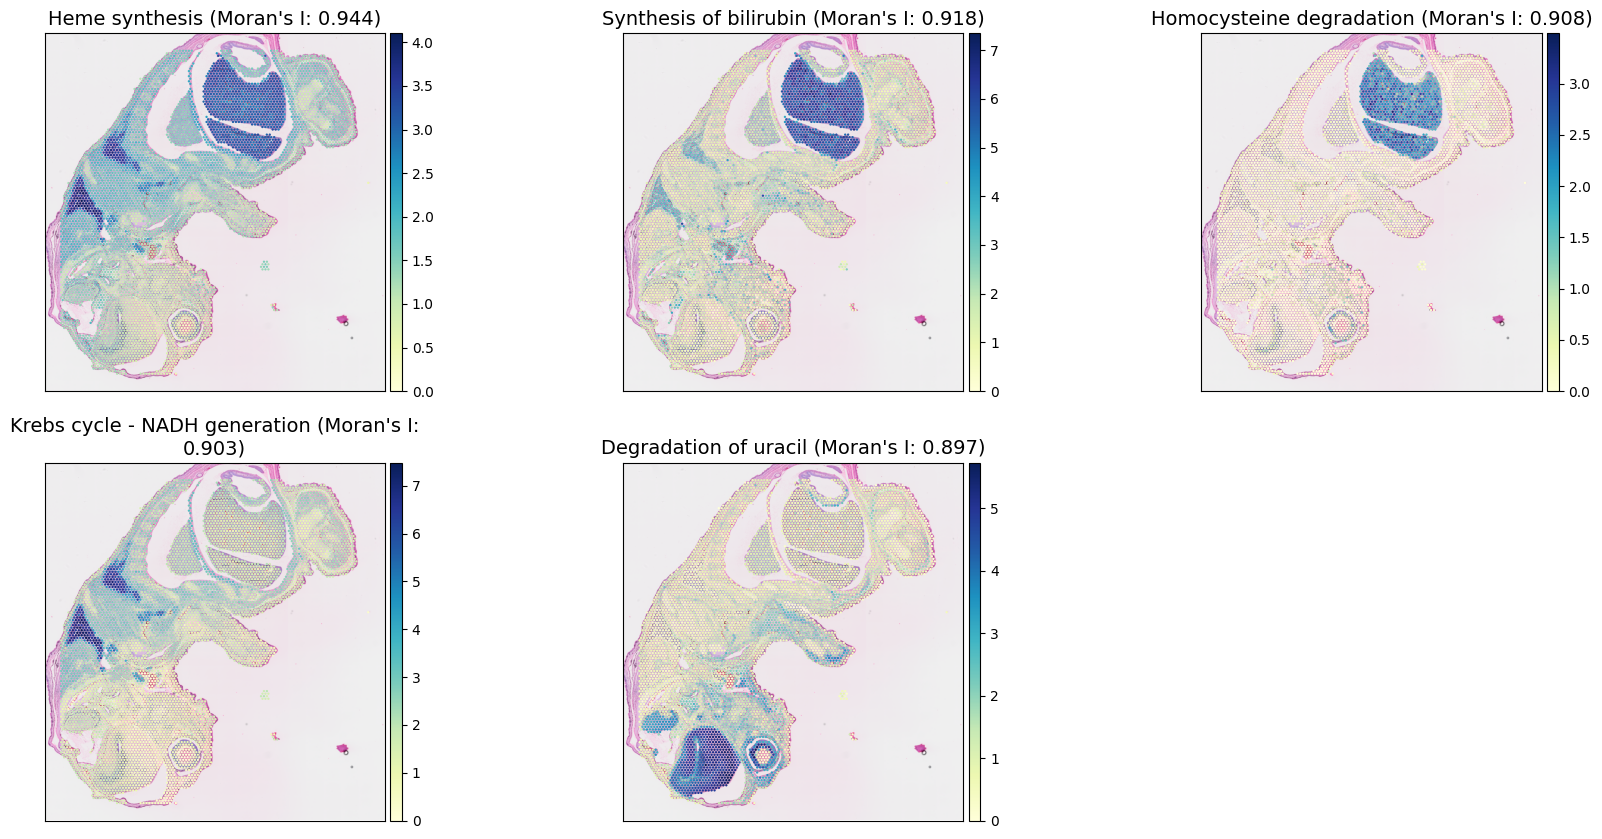

In [53]:
spa_inf_titles = [t + " (Moran's I: {:.3f})".format(top_moran.loc[t, 'I']) for t in spa_informative_var ]

## visualise only 5 markers due to notebook size    
fig, axes = sccellfie.plotting.plot_spatial(results['adata'].metabolic_tasks,
                                            keys=spa_informative_var [0:5],
                                            img_key='hires',
                                            cmap='YlGnBu',
                                            size=SPOT_SIZE,
                                            use_raw=False, 
                                            ncols=3,
                                            vmin=0,
                                            hspace=0.2,
                                            title=spa_inf_titles
                                            )

## Cell-cell communication <a class="anchor" id="cell-cell-communication"></a>

In [this tutorial](https://sccellfie.readthedocs.io/en/latest/notebooks/sc_communication.html) we infer cell-cell communication (CCC) for single-cell data, where we aggregate metabolic scores and gene expression into a cell type level to compute a communication score. However, for spatial data, scCellFie focuses on finding the co-localization of the synthesis of a metabolic and the receptor expression within a pre-defined neighborhood.

### Defining neighborhoods

We start defining our neighborhoods by finding an acceptable ratio where each spot is allocated with its immediate neighbors:

In [54]:
r = sccellfie.spatial.compute_neighbor_distribution(
    adata,
    radius_range=(100, 1500),  # adjust based on your data's scale
    n_points=200,
    spatial_key='spatial'
)

(<Figure size 1500x800 with 4 Axes>, GridSpec(2, 3))

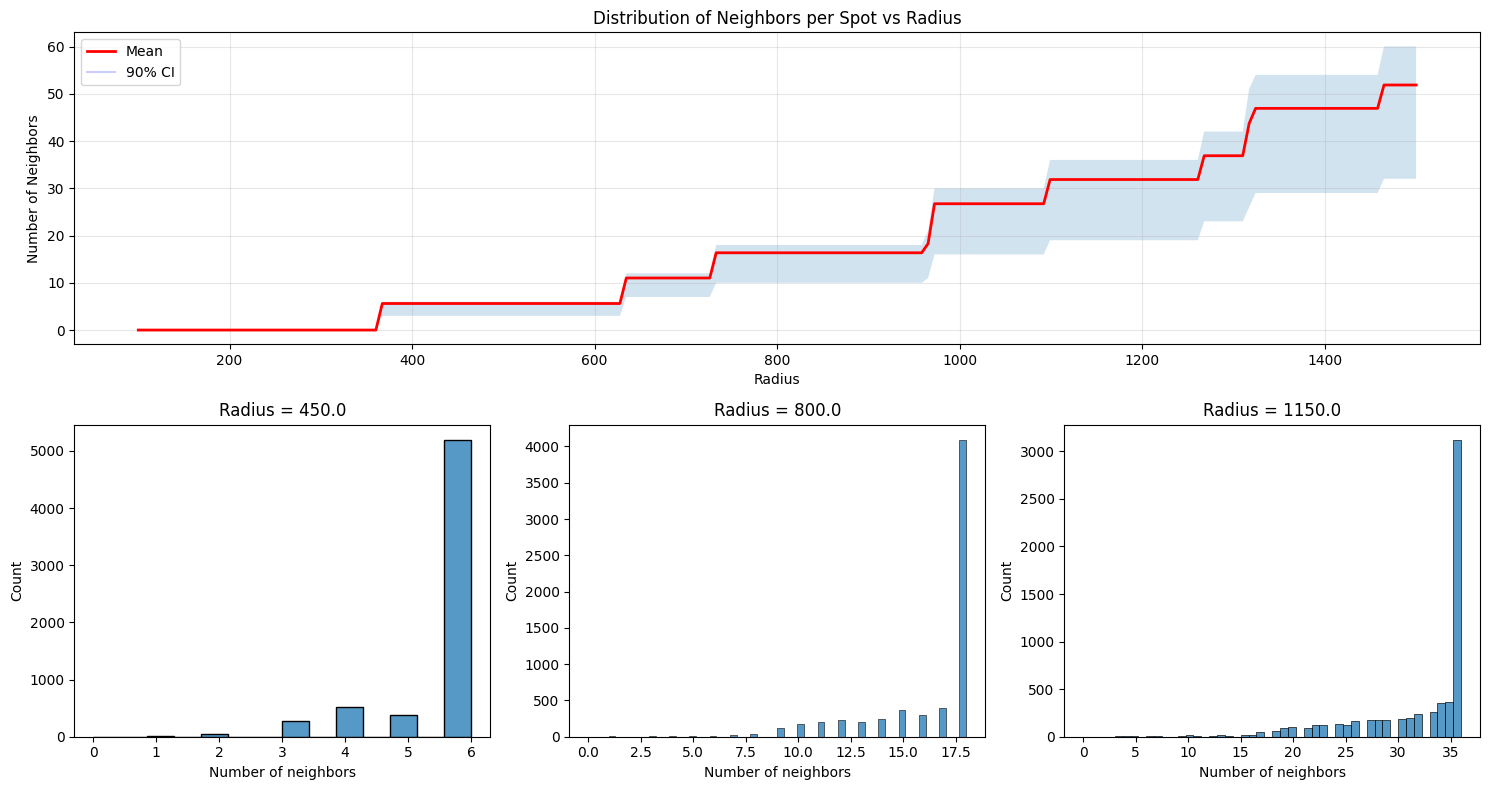

In [55]:
sccellfie.plotting.spatial.plot_neighbor_distribution(r)

Here, we select a radius of 450 to keep mode of neighbors (in distribution) of ~6 (immediate neighbors).

In [56]:
radius = 450

### Transfer metabolic tasks into gene expression (all variables in one AnnData object)

In [57]:
adata_updated = sccellfie.preprocessing.adata_utils.transfer_variables(
    adata_target=adata,
    adata_source=results['adata'].metabolic_tasks,
    var_names=results['adata'].metabolic_tasks.var_names
)

adata_updated

AnnData object with n_obs × n_vars = 6434 × 19487
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'size_factors'
    uns: 'dataset_description', 'dataset_id', 'dataset_name', 'dataset_organism', 'dataset_reference', 'dataset_summary', 'dataset_url', 'normalization_id', 'spatial', 'normalization', 'neighbors', 'umap', 'spatial_neighbors', 'spatial_network'
    obsm: 'spatial', 'X_pca', 'X_umap'
    layers: 'counts', 'normalized'
    obsp: 'distances', 'connectivities', 'spatial_connectivities', 'spatial_distances'

### Compute cell-cell communication based on synthesis and receptor pairs

As a demonstration, we selected the `'Synthesis of GABA'` to compute local co-localization scores for the pathway and its represented receptor `Gabra1`.

A ``'pairwise_concordance'`` score is computed by first identifying neighboring spots within a predefined radius (already done a couple of steps above). Each sender-receiver spot pair within the neighborhood is then evaluated.

To measure co-localization, we account for pairs of spots where one of partner presents a metabolic score above a threshold and the other has the receptor expression above another threshold. Here, we do not pass any threshold value, so scCellFie set them by default to be mean metabolic score and receptor expression across all spots. Finally, the co-localization score corresponds to the fraction of pairs of spots that were above the respective thresholds with respect the total number of pairs within a given neighborhood.

In [58]:
adata_updated.obs['GABA^Gabra1'] = sccellfie.communication.compute_local_colocalization_scores(
    adata_updated,
    var1='Synthesis of GABA',
    var2='Gabra1',
    neighbors_radius=radius,
    method='pairwise_concordance',
    min_neighbors=3,
    spatial_key='spatial',
    inplace=False
)

Then, we can visualize these synthesis of GABA, the expression of the receptor, the co-localization communication scores, and the main enzymes involved in this synthesis (`Gad1` and `Gad2`)

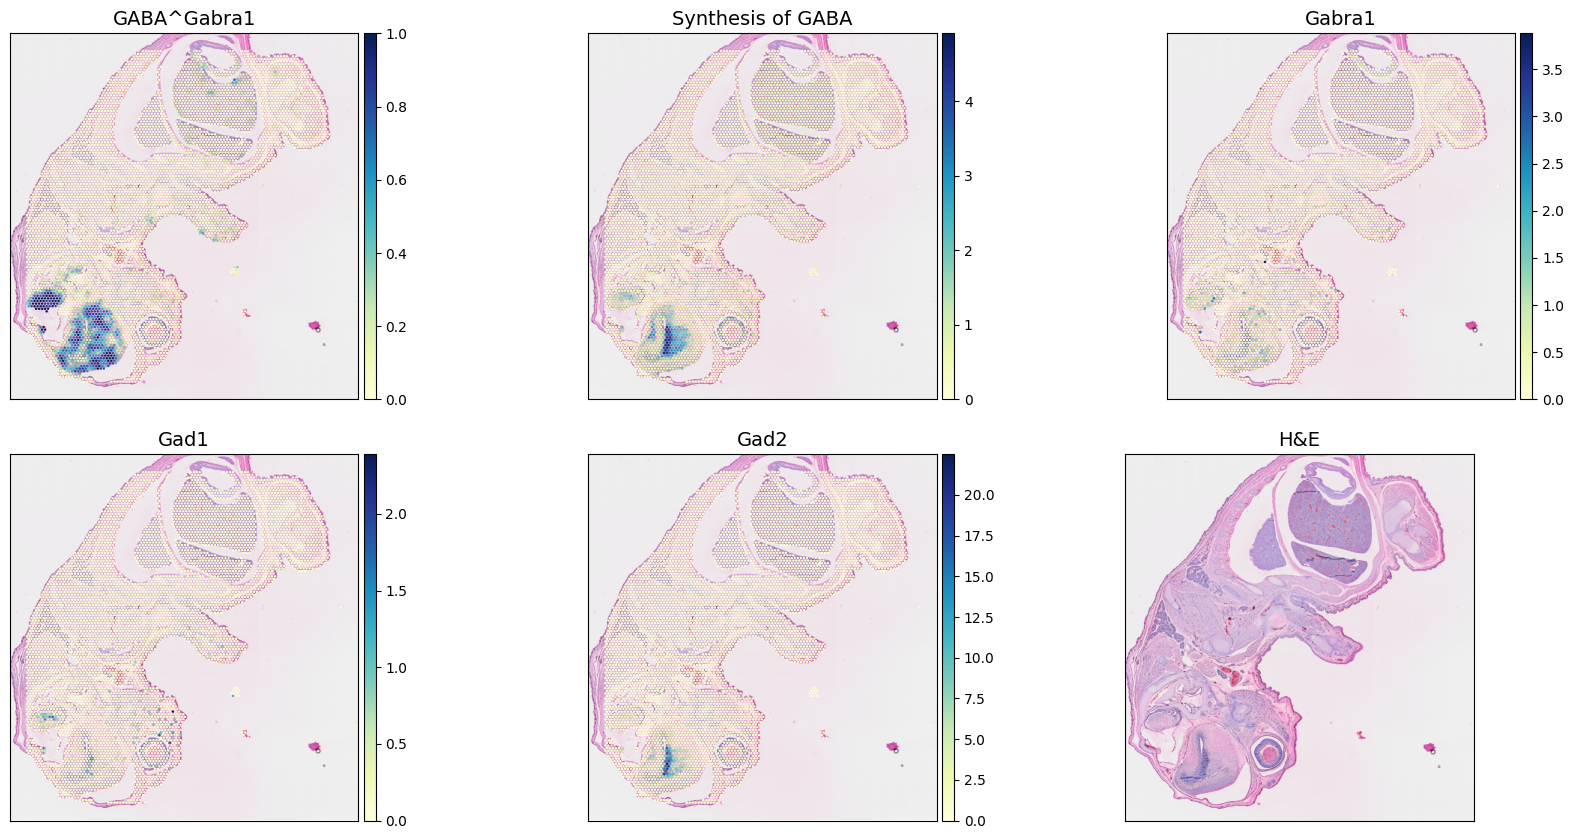

In [59]:
fig, axes = sccellfie.plotting.plot_spatial(adata_updated,
                                            keys=['GABA^Gabra1', 
                                                  'Synthesis of GABA', 
                                                  'Gabra1', # Receptor
                                                  'Gad1', # Synthase
                                                  'Gad2', # Synthase,
                                                  None # H&E
                                                  ],
                                            img_key="hires",
                                            cmap='YlGnBu',
                                            size=SPOT_SIZE,
                                            use_raw=False, 
                                            ncols=3,
                                            vmin=0,
                                            hspace=0.15   
                                            )